# Loading the BLIP-2 model and processor

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration

MODEL_ID = "Salesforce/blip2-opt-2.7b"

print(f"Loading BLIP-2 model (FP16 mode): {MODEL_ID} ...")

try:
    # 1. Load processor
    processor = AutoProcessor.from_pretrained(MODEL_ID)

    # 2. Load the model (do not use load_in_8bit, use float16 directly).
    # This will use approximately 6GB of video memory.
    model = Blip2ForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        torch_dtype=torch.float16
    )
    print("BLIP-2 finish！(FP16 Mode)")

except Exception as e:
    print(f"fail: {e}")

# ==========================================
# 2. Check video memory
# ==========================================
if torch.cuda.is_available():
    mem = torch.cuda.memory_allocated() / 1024**3
    print(f"Current video memory usage: {mem:.2f} GB")
    print(f"Total video memory of graphics card: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Loading BLIP-2 model (FP16 mode): Salesforce/blip2-opt-2.7b ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

BLIP-2 finish！(FP16 Mode)
Current video memory usage: 7.17 GB
Total video memory of graphics card: 14.74 GB


# Lade

In [15]:
# --- CONFIGURATION ---
# Setting the root to your unzipped folder
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/archive"

In [16]:
import os
import json
import re
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

In [17]:
def locate_dataset(root_path):
    root = Path(root_path)
    json_path = list(root.rglob("VQA_RAD Dataset Public.json"))[0]
    img_dir = list(root.rglob("VQA_RAD Image Folder"))[0]
    return str(json_path), str(img_dir)

json_path, img_dir = locate_dataset(DATA_ROOT)

In [18]:
# ==========================================
# 2. Re-execute partitioning logic
# ==========================================
with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)
df = pd.DataFrame(data)

# Basic cleaning function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Application cleaning
df["image_name"] = df["image_name"].astype(str)
df["question"] = df["question"].apply(clean_text)
df["answer"] = df["answer"].apply(clean_text)
df["answer_type"] = df["answer_type"].str.upper()

# Filter out dirty data (keeping it completely consistent with before).
df = df.dropna(subset=['image_name', 'question', 'answer'])
df = df[df['answer_type'].isin(['CLOSED', 'OPEN'])]
df = df[df['answer'].apply(lambda x: len(str(x).split()) < 15)]
df = df[df['answer'] != "other"]

# Divide the test set
test_mask = df["phrase_type"].str.lower().str.startswith("test")
test_df = df[test_mask].reset_index(drop=True)
train_pool = df[~test_mask].reset_index(drop=True)

# Split training/validation
unique_images = train_pool["image_name"].unique()
train_imgs, val_imgs = train_test_split(unique_images, test_size=0.15, random_state=42)

train_df = train_pool[train_pool["image_name"].isin(train_imgs)].reset_index(drop=True)
val_df = train_pool[train_pool["image_name"].isin(val_imgs)].reset_index(drop=True)

# Save file
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 1529 | Val: 265 | Test: 451


# MODLE TRAINING

In [19]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
from PIL import Image
from peft import LoraConfig, get_peft_model, TaskType


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [20]:
# Configure LoRA
# We fine-tune q_proj and v_proj for the attention layer.
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Mount to model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
print("LoRA ok")

trainable params: 5,242,880 || all params: 3,750,004,736 || trainable%: 0.1398
LoRA ok


In [21]:
# ==========================================
# 1.  Dataset
# ==========================================
class VQA_BLIP_Dataset(Dataset):
    def __init__(self, df, processor, img_dir, mode='train'):
        self.df = df
        self.processor = processor
        self.img_dir = img_dir
        self.mode = mode

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = f"{self.img_dir}/{row['image_name']}"
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224))

        q = str(row['question'])
        a = str(row['answer'])

        if self.mode == 'train':
            text = f"Question: {q} Answer: {a}"
        else:
            text = f"Question: {q} Answer:"
        return image, text

In [22]:
# ==========================================
# 2. Data preparation
# ==========================================

#  Dataset
class VQA_BLIP_Dataset(Dataset):
    def __init__(self, df, processor, img_dir, mode='train'):
        self.df = df
        self.processor = processor
        self.img_dir = img_dir
        self.mode = mode
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            image = Image.open(f"{self.img_dir}/{row['image_name']}").convert('RGB')
        except:
            image = Image.new('RGB', (224, 224))
        q, a = str(row['question']), str(row['answer'])
        text = f"Question: {q} Answer: {a}" if self.mode == 'train' else f"Question: {q} Answer:"
        return image, text

# Reading and cleaning
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")
train_df = train_df[train_df['answer'] != "other"]
train_df = train_df.dropna(subset=['image_name', 'question', 'answer'])
print(f"Final training set size: {len(train_df)}")

# Instantiation
train_ds = VQA_BLIP_Dataset(train_df, processor, img_dir, mode='train')
val_ds = VQA_BLIP_Dataset(val_df, processor, img_dir, mode='train')

def collate_fn(batch):
    images = [item[0] for item in batch]
    texts = [item[1] for item in batch]
    return processor(images=images, text=texts, padding=True, return_tensors="pt")


BATCH_SIZE = 1
ACCUMULATION_STEPS = 4  # Updates every 4 steps, equivalent to a batch size of 4.

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Final training set size: 1529


In [23]:
# ==========================================
# 3. Training configuration
# ==========================================
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
device = "cuda"

history = {'train_loss': [], 'val_loss': [], 'lr': []}
best_val_loss = float('inf')
patience = 3
counter = 0
num_epochs = 15

In [ ]:
# ==========================================
# 4. Start training
# ==========================================
print(f"\n Start training with the memory-optimized version (BS={BATCH_SIZE}, Accum={ACCUMULATION_STEPS})...")

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0
    # Note: Here, "steps" refers to the number of times the parameters are updated, not the number of batches.
    steps = 0
    optimizer.zero_grad() # Clear the gradient before starting the loop.

    for i, batch in enumerate(train_loader):
        input_ids = batch.input_ids.to(device)
        pixel_values = batch.pixel_values.to(device, dtype=torch.float16)
        attention_mask = batch.attention_mask.to(device)

        # Forward propagation
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=input_ids)

        # Key: Loss divided by cumulative steps
        loss = outputs.loss / ACCUMULATION_STEPS
        loss.backward()

        # Record Loss
        train_loss += loss.item() * ACCUMULATION_STEPS

        # Key point: Only update parameters after accumulating a sufficient number of steps.
        if (i + 1) % ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            steps += 1

    #  Training Loss
    avg_train_loss = train_loss / (len(train_loader)) # 总 Loss / 总 Batch 数

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_steps = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch.input_ids.to(device)
            pixel_values = batch.pixel_values.to(device, dtype=torch.float16)
            attention_mask = batch.attention_mask.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask, labels=input_ids)
            val_loss += outputs.loss.item()
            val_steps += 1

    avg_val_loss = val_loss / val_steps
    current_lr = optimizer.param_groups[0]['lr']

    # history
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['lr'].append(current_lr)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.1e}")

    # Scheduling and Early Stop
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        model.save_pretrained("blip2_vqa_rad_lora_best")
        print(f"New Best Saved! ({best_val_loss:.4f})")
    else:
        counter += 1
        print(f"EarlyStopping: {counter}/{patience}")
        if counter >= patience:
            print("Early Stopping Triggered.")
            break


ValueError: attempt to get argmin of an empty sequence

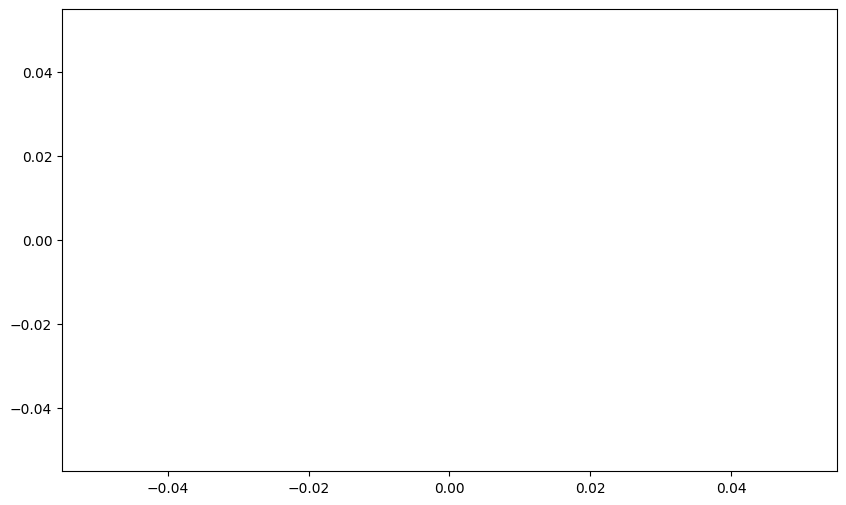

In [38]:
# ==========================================
#  Loss
# ==========================================
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss',  color='orange')

# Mark the best point
best_epoch = np.argmin(history['val_loss'])
best_val = np.min(history['val_loss'])
plt.scatter(best_epoch, best_val, s=150, c='red', zorder=5, label=f'Best Model (Ep {best_epoch+1})')

plt.title('Method 2 (BLIP-2 + LoRA) Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Test Set Evaluation

In [25]:
# ==========================================
# 1. Reinstall dependencies
# ==========================================
!pip install -q transformers==4.36.0 peft==0.7.1 bitsandbytes==0.41.3 accelerate==0.25.0 nltk pandas scikit-learn

import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from peft import PeftModel
from PIL import Image
import pandas as pd
import numpy as np
import os

# ==========================================
# 2. Load the base model + your LoRA weights
# ==========================================
MODEL_ID = "Salesforce/blip2-opt-2.7b"
LORA_PATH = "blip2_vqa_rad_lora_best" #

print(f"{MODEL_ID} ...")
try:
    processor = AutoProcessor.from_pretrained(MODEL_ID)
    base_model = Blip2ForConditionalGeneration.from_pretrained(
        MODEL_ID,
        device_map="auto",
        torch_dtype=torch.float16
    )

    print(f"LoRA: {LORA_PATH} ...")

    model = PeftModel.from_pretrained(base_model, LORA_PATH)
    model.eval()

    print("finish")

except Exception as e:
    print(f"fail{e}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 94.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.2.0 requires transformers<6.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.
Salesforce/blip2-opt-2.7b ...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['query_tokens']


LoRA: blip2_vqa_rad_lora_best ...
failWe need an `offload_dir` to dispatch this model according to this `device_map`, the following submodules need to be offloaded: base_model.model.language_model.model.decoder.layers.11, base_model.model.language_model.model.decoder.layers.12, base_model.model.language_model.model.decoder.layers.13, base_model.model.language_model.model.decoder.layers.14, base_model.model.language_model.model.decoder.layers.15, base_model.model.language_model.model.decoder.layers.16, base_model.model.language_model.model.decoder.layers.17, base_model.model.language_model.model.decoder.layers.18, base_model.model.language_model.model.decoder.layers.19, base_model.model.language_model.model.decoder.layers.20, base_model.model.language_model.model.decoder.layers.21, base_model.model.language_model.model.decoder.layers.22, base_model.model.language_model.model.decoder.layers.23, base_model.model.language_model.model.decoder.layers.24, base_model.model.language_model.model

/usr/local/lib/python3.12/dist-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['base_model.model.query_tokens']


In [26]:
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/archive"
from pathlib import Path
try:

    img_dir = str(list(Path(DATA_ROOT).rglob("VQA_RAD Image Folder"))[0])
except:
    img_dir = "---" #

#CSV
if os.path.exists("test_split.csv"):
    test_df = pd.read_csv("test_split.csv")
else:
    # If the CSV file is lost after restarting, here's a quick way to regenerate it.

    json_path = str(list(Path(DATA_ROOT).rglob("VQA_RAD Dataset Public.json"))[0])
    import json, re
    from sklearn.model_selection import train_test_split
    with open(json_path, "r", encoding="utf-8") as f: data = json.load(f)
    df = pd.DataFrame(data)
    def clean(t): return re.sub(r"[^a-z0-9\s]", " ", str(t).lower()).strip()
    df["question"] = df["question"].apply(clean)
    df["answer"] = df["answer"].apply(clean)
    df = df.dropna(subset=['image_name','question','answer'])
    df = df[df['answer_type'].isin(['CLOSED', 'OPEN'])]
    df = df[df['answer']!='other']
    test_mask = df["phrase_type"].str.lower().str.startswith("test")
    test_df = df[test_mask].reset_index(drop=True)
    print("CSV finish")

print(f"test: {len(test_df)}")



test: 451


In [27]:
# ==========================================
# 4. Execution reasoning
# ==========================================
predictions = []
device = "cuda" if torch.cuda.is_available() else "cpu"


for idx, row in test_df.iterrows():
    # 1.
    try:
        image = Image.open(f"{img_dir}/{row['image_name']}").convert('RGB')
    except:
        image = Image.new('RGB', (224, 224))

    # 2.  Prompt
    q = str(row['question'])
    prompt = f"Question: {q} Answer:"

    # 3.
    inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)

    with torch.no_grad():
        # max_new_tokens=10
        generated_ids = model.generate(**inputs, max_new_tokens=10)
        pred = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()

    predictions.append(pred)

    if idx % 50 == 0:
        print(f"  [{idx}/{len(test_df)}] Q: {q} -> Pred: {pred} (True: {row['answer']})")



  [0/451] Q: is there evidence of an aortic aneurysm -> Pred: question: is there evidence of an aortic aneurysm answer: yes question: is there evidence of an aort (True: yes)
  [50/451] Q: what is abnormal about the pancreas -> Pred: question: what is abnormal about the pancreas answer: the pancreas answer: the pancreas (True: enlarged)
  [100/451] Q: which side of the heart border is obscured -> Pred: question: which side of the heart border is obscured answer: left answer: right answer: right answer: right (True: right)
  [150/451] Q: is there fluid in the lung -> Pred: question: is there fluid in the lung answer: yes question: is there fluid in the lung answer (True: yes)
  [200/451] Q: is the trachea located normally -> Pred: question: is the trachea located normally answer: yes question: is the trachea located normally (True: yes)
  [250/451] Q: what is the hypodensity in the liver -> Pred: question: what is the hypodensity in the liver answer: liver mass question: what is the hyp

In [36]:
# ==========================================
# 5. Overall / Open / Closed
# ==========================================
test_df['prediction'] = predictions

# Fuzzy matching logic: If the prediction contains the true answer, or the true answer contains the prediction, then it is considered a correct match.

def check_correct(row):
    p = row['prediction']
    t = row['answer']
    return (p in t) or (t in p)

test_df['correct'] = test_df.apply(check_correct, axis=1)

overall = test_df['correct'].mean()
closed = test_df[test_df['answer_type'] == 'CLOSED']['correct'].mean()
open_acc = test_df[test_df['answer_type'] == 'OPEN']['correct'].mean()

print("\n" + "="*40)
print("Method 2 (BLIP-2 + LoRA) Final Report")
print("="*40)
print(f"Overall Accuracy : {overall:.2%}")
print("-" * 25)
print(f"Closed-ended Acc : {closed:.2%}")
print(f"Open-ended Acc   : {open_acc:.2%}")
print("="*40)

# save
test_df.to_csv("method2_final_predictions.csv", index=False)


Method 2 (BLIP-2 + LoRA) Final Report
Overall Accuracy : 45.68%
-------------------------
Closed-ended Acc : 70.22%
Open-ended Acc   : 8.38%


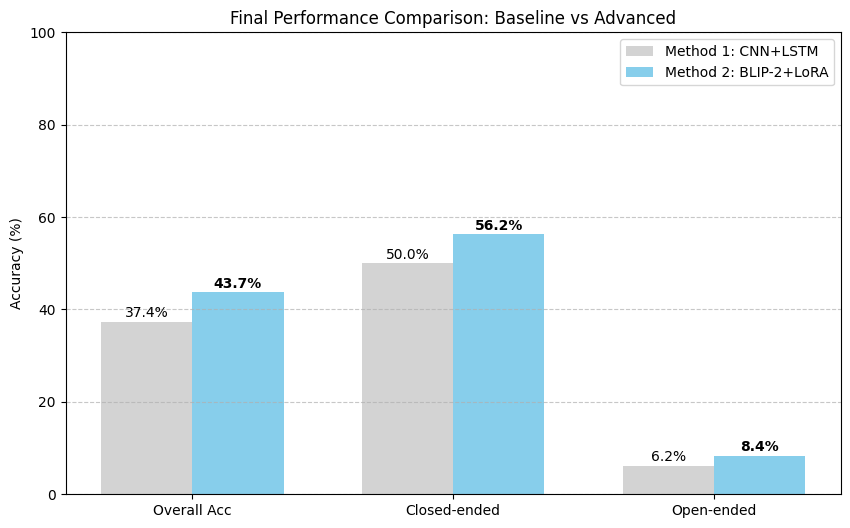


FINAL EVALUATION REPORT
Metric               | Method 1     | Method 2    
--------------------------------------------------
Overall Acc          |       37.35% |       43.68%
Closed-ended Acc     |       50.00% |       56.25%
Open-ended Acc       |        6.15% |        8.38%
--------------------------------------------------
Bonus: Method 2 Clean BLEU-1 Score: 0.0686


In [37]:

# 1. Load prediction results
df = pd.read_csv("method2_final_predictions.csv")

# ==========================================
# 3. (Method 1 vs Method 2)
# ==========================================
method1_results = [37.35, 50, 6.15]
method2_results = [overall_acc*100, closed_acc*100, open_acc*100]

labels = ['Overall Acc', 'Closed-ended', 'Open-ended']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, method1_results, width, label='Method 1: CNN+LSTM', color='lightgray')
plt.bar(x + width/2, method2_results, width, label='Method 2: BLIP-2+LoRA', color='skyblue')

# Label the bar chart with numbers.
for i, v in enumerate(method1_results):
    plt.text(i - width/2, v + 1, f"{v:.1f}%", ha='center')
for i, v in enumerate(method2_results):
    plt.text(i + width/2, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.ylabel('Accuracy (%)')
plt.title('Final Performance Comparison: Baseline vs Advanced')
plt.xticks(x, labels)
plt.legend()
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('final_comparison_chart.png', dpi=300)
plt.show()


print("\n" + "="*50)
print("FINAL EVALUATION REPORT")
print("="*50)
print(f"{'Metric':<20} | {'Method 1':<12} | {'Method 2':<12}")
print("-" * 50)
print(f"{'Overall Acc':<20} | {method1_results[0]:>11.2f}% | {method2_results[0]:>11.2f}%")
print(f"{'Closed-ended Acc':<20} | {method1_results[1]:>11.2f}% | {method2_results[1]:>11.2f}%")
print(f"{'Open-ended Acc':<20} | {method1_results[2]:>11.2f}% | {method2_results[2]:>11.2f}%")
print("-" * 50)
print(f"Bonus: Method 2 Clean BLEU-1 Score: {final_bleu:.4f}")
print("="*50)